In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from __future__ import annotations
%matplotlib widget

from typing import TypeAlias
Vector: TypeAlias = np.ndarray  # A 1-D array
Matrix: TypeAlias = np.ndarray  # A 2-D array

In [2]:
class LayerInitializationStrategy:
    """Parent class for initialization strategies of weights and biases in Layer."""
    def run(self, size_of_previous_layer: int, size_of_current_layer: int) -> tuple[np.ndarray, np.ndarray]:
        raise NotImplementedError("The 'run' method is implemented only in child classes")

class RandomUniform(LayerInitializationStrategy):
    """
    Initialization strategy sampling weights and biases uniformly in a given interval.

    Attributes
    ----------
    scale: float
        The half-lenght of the interval [-scale, scale] from which values are sampled.

    Methods
    -------
    run(self, size_of_previous_layer: int, size_of_current_layer: int) -> tuple[np.ndarray, np.ndarray]
        Returns the tuple (random_weights, random_biases), where random_weights and random_biases are np.ndarrays of the appropriate shape.
    """
    def __init__(self, scale_of_interval: float, center_of_interval: float = 0):
        self.scale: float = scale_of_interval
        self.center: float = center_of_interval
        
    
    def run(self, size_of_previous_layer: int, size_of_current_layer: int) -> tuple[np.ndarray, np.ndarray]:
        random_weights: np.ndarray = np.random.uniform(
            -self.scale + self.center, self.scale + self.center,
            (size_of_previous_layer, size_of_current_layer)
            )
        random_biases: np.ndarray = np.random.uniform(
            -self.scale + self.center, self.scale + self.center,
            size_of_current_layer
            )
        return random_weights, random_biases

In [3]:
class ActivationFunction:
    """Parent class for activation functions of neural nodes."""
    def __call__(self, x: np.ndarray) -> np.ndarray:
        raise NotImplementedError("The '__call__' method must be implemented in child classes")

    def derivative(self, x: np.ndarray) -> np.ndarray:
        raise NotImplementedError("The 'derivative' method must be implemented in child classes")

class Sigmoid(ActivationFunction):
    """Sigmoid activation function. f(x) = 1 / (1 + np.exp(-x))"""
    def __call__(self, x: np.ndarray) -> np.ndarray:
        return 1 / (1 + np.exp(-x))

    def derivative(self, x: np.ndarray) -> np.ndarray:
        sigmoid = self(x)  # Reuse the __call__ method to compute sigmoid
        return sigmoid * (1 - sigmoid)

In [4]:
class Layer:
    """
    A Layer component of a NeuralNetwork.

    Attributes
    ----------
    unit_number: int
        The number of nodes/units in the Layer.
    init_strat: LayerInitializationStrategy
        The initialization strategy for the weights and biases of the Layer
    activation_function: ActivationFunction
        The function.
    
    I should continue writing docstrings later
    """

    def __init__(self, number_of_units: int,
                 initialization_strategy: LayerInitializationStrategy,
                 activation_function: ActivationFunction):
        self.unit_number: int = number_of_units  # The number of nodes/units in the Layer.
        self.init_strat: LayerInitializationStrategy = initialization_strategy
        self.activation_function: ActivationFunction = activation_function
        self.linear_output: Vector = None
        self.output: Vector = None  # The values computed by the units based on the outputs of the previous layer. Stored for later backprop.
        self.previous_layer: Layer = None  # The layer preceding the current one in the Neural Network. The NN should connect layers during initialization.
        self.next_layer: Layer = None
        self.weights: Matrix = None; self.biases: Vector = None  # Weights and biases connecting the layer with the previous layer of the neural network.
        self.delta: Vector = None
        

    def initialize_weights(self):
        self.weights, self.biases = self.init_strat.run(self.previous_layer.unit_number, self.unit_number)

    def compute_output(self):
        self.linear_output = np.dot(self.previous_layer.output, self.weights) + self.biases
        self.output: Vector = self.activation_function(self.linear_output)
        return self.output
    
    
    # def compute_gradient(self)  # Should this function be here or in a later TrainingAlgorithm class?

class InputLayer(Layer):
    def __init__(self, number_of_units: int):
        super().__init__(number_of_units, None, None)
        # An input layer has no previous layer to connect to, so attributes referring to a previous layer are deleted.
        del self.previous_layer, self.weights, self.biases, self.init_strat, self.activation_function
    
    def feed_input(self, value: Vector) -> None:
        self.output: Vector = value
    
    def initialize_weights(self):
        raise NotImplementedError("InputLayer does not require weight initialization.")

    def compute_output(self):
        return self.output

class HiddenLayer(Layer):
    def backward(self):
        self.delta = np.dot(self.next_layer.weights, self.next_layer.delta) * self.activation_function.derivative(self.linear_output)

class OutputLayer(Layer):
    def __init__(self, number_of_units: int,
                 initialization_strategy: LayerInitializationStrategy,
                 activation_function: ActivationFunction):
        super().__init__(number_of_units, initialization_strategy, activation_function)
        del self.next_layer

In [5]:
class ListOfArrays:
    """
    An utility class for defining element-wise operations on lists containing heteromorphic np.ndarrays.
    Useful for storing network weights and biases in MLP-architecture NeuralNetworks.
    """
    def __init__(self, arrays: list[np.ndarray]):
        self.arrays: list[np.ndarray] = arrays
    
    def __repr__(self):
        return f"ListOfArrays{(self.arrays)}"

    def __getitem__(self, index):
        return self.arrays[index]

    def __setitem__(self, index, value):
        self.arrays[index] = value
    
    def __add__(self, other):
        if not isinstance(other, ListOfArrays): raise TypeError("Operand is not a ListOfArrays")
        return ListOfArrays([x + y for x, y in zip(self.arrays, other.arrays)])
    
    def __mul__(self, scalar: float):
        return ListOfArrays([x * scalar for x in self.arrays])
    
    def __rmul__(self, scalar: float):
        return self.__mul__(scalar)

    def __truediv__(self, scalar: float):
        return ListOfArrays([x / scalar for x in self.arrays])
    
    def __pow__(self, power: float):
        return ListOfArrays([x**power for x in self.arrays])
    
    def sum(self) -> float:
        return np.sum([np.sum(array) for array in self.arrays])
    
    def set_all_values_to(self, value: float) -> None:
        for a in self.arrays:
            a = value*np.ones(a.shape)


class ListOfVectors(ListOfArrays):
    def __init__(self, arrays: list[Vector]):
        super().__init__(arrays)

class ListOfMatrices(ListOfArrays):
    pass
    def __init__(self, arrays: list[Matrix]):
        super().__init__(arrays)

In [6]:
class NeuralNetwork:
    def __init__(self, layers: list[Layer]):
        self.layers: list[Layer] = layers
        # Maybe here I should ensure that layers are correctly typed (layers[0] should be an InputLayer, layers[-1] an OutputLayer, all other layers should be HiddenLayer).
        self.input_layer: InputLayer = layers[0]; self.hidden_layers: list[HiddenLayer] = layers[1: -1]; self.output_layer: OutputLayer = layers[-1]
        self.layers_with_weights: list[Layer] = self.layers[1: ]
        self.connect_layers()
        self.initialize_weights()

    
    def connect_layers(self) -> None:
        for (i, layer) in enumerate(self.layers):
            if not isinstance(layer, InputLayer): layer.previous_layer = self.layers[i - 1]
            if not isinstance(layer, OutputLayer): layer.next_layer = self.layers[i + 1]

    def initialize_weights(self) -> None:
        for layer in self.layers_with_weights: layer.initialize_weights()
    
    def feed_input(self, value: np.ndarray) -> None:
        self.input_layer.feed_input(value)

    def activate_network(self) -> np.ndarray:
        for i in range(len(self.layers)): self.layers[i].compute_output()
        return self.output_layer.output
    
    def compute_output(self, value: np.ndarray) -> np.ndarray:
        self.feed_input(value)
        return self.activate_network()
    
    def backward(self) -> None:
        for l in reversed(self.hidden_layers):
            l.backward()
    
    def compute_multiple_outputs(self, x_data: pd.DataFrame | np.ndarray) -> np.ndarray[np.ndarray]:
        if isinstance(x_data, pd.DataFrame): x_data = x_data.to_numpy()
        outputs = np.array(
            [
                self.compute_output(x_data[i]) for i in range(len(x_data))
            ]
        )
        return outputs

In [7]:
class RegularizationTerm:
    def set_network(self, network: NeuralNetwork) -> None:
        self.network = network

    def __call__(self) -> float:
        pass

    def gradient(self) -> tuple[ListOfArrays, ListOfArrays]:
        pass

class NoRegularization(RegularizationTerm):
    def __init__(self):
        pass

    def __call__(self) -> float:
        return 0
    
    def gradient(self) -> tuple[ListOfArrays, ListOfArrays]:
        layers = self.network.layers_with_weights
        return ListOfArrays([np.zeros_like(l.weights) for l in layers]), ListOfArrays([np.zeros_like(l.biases) for l in layers])

class Tikhonov(RegularizationTerm):
    def __init__(self, penalty: float):
        self.penalty: float = penalty
        self.network: NeuralNetwork = None

    def __call__(self) -> float:
        layers: list[Layer] = self.network.layers_with_weights
        weights_term = np.sum([np.sum(layer.weigths**2) for layer in layers])  # The sum of squares of all the weights in the NN.
        biases_term = np.sum([np.sum(layer.biases**2) for layer in layers])
        return self.penalty * (weights_term + biases_term) / 2

    def gradient(self) -> tuple[ListOfArrays, ListOfArrays]:
        layers: list[Layer] = self.network.layers_with_weights
        gradient_on_weights: ListOfArrays = ListOfArrays([-self.penalty * l.weights for l in layers])
        gradient_on_biases: ListOfArrays = ListOfArrays([-self.penalty * l.biases for l in layers])
        return gradient_on_weights, gradient_on_biases

In [8]:
class MomentumRule:
    pass

In [9]:
#class TrainingAlgorithm: pass

class StoppingCondition:
    def __init__(self):
        self.alg: TrainingAlgorithm = None
    
    def set_alg(self, alg: TrainingAlgorithm) -> None:
        self.alg = alg

    @property
    def is_satisfied(self) -> bool:
        pass

class ThresholdOnTrainingError(StoppingCondition):
    def __init__(self, threshold: float, patience: int):
        super().__init__()
        self.threshold: float = threshold
        self.patience: int = patience
    
    @property
    def is_satisfied(self) -> bool:
        current_training_error: float = self.alg.current_tr_err
        if current_training_error < self.threshold:
            self.consecutive_epochs += 1
            return self.consecutive_epochs > self.patience
        else:
            self.consecutive_epochs = 0
            return False

In [10]:
class ErrorFunction:
    def __call__(self, y_data: np.ndarray, y_predicted: np.ndarray) -> float:
        pass
    
    def simple_gradient(self, y_data: np.ndarray, y_predicted: np.ndarray) -> np.ndarray:
        pass

class MSE(ErrorFunction):
    def __call__(self, y_data: np.ndarray, y_predicted: np.ndarray) -> float:
        """
        Returns the average over the dataset of the square euclidean distance between the training outputs and the predictions.
        """
        num_patterns = 1 if y_data.ndim == 1 else len(y_data)
        return 0.5 * np.sum((y_data - y_predicted)**2) / num_patterns
    
    def simple_gradient(self, y_data: np.ndarray, y_predicted: np.ndarray) -> np.ndarray:
        """
        Returns y_data - y_predicted. It is meant to be used on a single pattern at a time, during backpropagation.
        """
        return (y_data - y_predicted)

In [11]:
class Dataset:
    def __init__(self, x_data: Matrix, y_data: Matrix):
        """
        Initializes the dataset with input (x_data) and output (y_data).
        """
        if x_data.ndim == 1 or y_data.ndim == 1:
            raise ValueError(f"x_data and y_data should be matrices, where each row represents a pattern and each column a feature, but got arguments of shape {x_data.shape} and {y_data.shape}")

        self.x: Matrix = x_data
        self.y: Matrix = y_data
    
    def __len__(self):
        """
        Returns the number of patterns in the dataset.
        """
        return len(self.x)
    
    def __getitem__(self, index):
        """
        Retrieves the input-output pair at the specified index.
        """
        return self.x[index], self.y[index]  


class DataManager:
    def __init__(self, dataset: Dataset, minibatch_size: int = None, shuffle: bool = False):
        self.dataset: Dataset = dataset
        self.minibatch_size: int = minibatch_size or len(dataset)
        self.shuffle: bool = shuffle
    
    def __iter__(self):
        """
        An iterator yielding minibatches.
        """
        indices = np.arange(len(self.dataset))
        
        if self.shuffle:
            np.random.shuffle(indices)
        
        for start in range(0, len(indices), self.minibatch_size):
            minibatch_indices = indices[start:start + self.minibatch_size]
            minibatch_x = self.dataset.x[minibatch_indices, :]
            minibatch_y = self.dataset.y[minibatch_indices, :]
            yield minibatch_x, minibatch_y

In [12]:
class TrainingAlgorithm:
    def __init__(self, x_train: pd.DataFrame, y_train: pd.DataFrame, network: NeuralNetwork):
        self.network: NeuralNetwork = network

        self.training_set = Dataset(x_train.to_numpy(), y_train.to_numpy())

        self.current_tr_err: float = float('inf')

        self.history: dict[list] = {'training error': []}
        self.cache: dict = {}

class Backprop(TrainingAlgorithm):
    def __init__(self, x_train: pd.DataFrame, y_train: pd.DataFrame, network: NeuralNetwork,
                 learning_rate: float,
                 error_function: ErrorFunction,
                 stopping_condition: StoppingCondition,
                 regularization_term: RegularizationTerm = None,
                 minibatch_size: int = None
                 ):
        super().__init__(x_train, y_train, network)

        self.learning_rate: float = learning_rate

        self.err_fun: ErrorFunction = error_function
        
        self.stop_cond: StoppingCondition = stopping_condition
        self.stop_cond.set_alg(self)

        self.weights_gradient: ListOfMatrices = ListOfMatrices([np.zeros_like(l.weights) for l in self.network.layers_with_weights])
        self.biases_gradient: ListOfVectors = ListOfVectors([np.zeros_like(l.biases) for l in self.network.layers_with_weights])

        self.regularization_term: RegularizationTerm = regularization_term or NoRegularization()
        self.regularization_term.set_network(self.network)

        self.minibatch_size: int = minibatch_size or len(self.training_set)
        self.minibatch_generator: DataManager = DataManager(self.training_set, self.minibatch_size,
                                                            shuffle = (self.minibatch_size != len(self.training_set))
                                                            )
        self.current_mb_size: int = None
        self.current_mb_x: Matrix = None; self.current_mb_y: Matrix = None
        
    
    def run(self, max_epochs: int) -> None:
        epoch: int = 0
        while epoch < max_epochs:
            epoch += 1

            for minibatch_x, minibatch_y in self.minibatch_generator:
                self.update_minibatch_metadata(minibatch_x, minibatch_y)
                self.update_gradients()
                self.update_network_parameters()
            
            self.compute_training_error()
            if self.stop_cond.is_satisfied: break

    def update_minibatch_metadata(self, minibatch_x: Matrix, minibatch_y: Matrix):
        self.current_mb_x = minibatch_x; self.current_mb_y = minibatch_y
        self.current_mb_size = len(minibatch_x)
    
    def update_gradients(self):
        self.reset_gradients()

        for x, y in zip(self.current_mb_x, self.current_mb_y):
            predicted_y = self.network.compute_output(x)
            out_l = self.network.output_layer
            out_l.delta = self.err_fun.simple_gradient(y, predicted_y)*out_l.activation_function.derivative(out_l.linear_output)
            self.network.backward()
            self.weights_gradient += ListOfMatrices([np.outer(l.previous_layer.output, l.delta) for l in self.network.layers_with_weights])
            self.biases_gradient += ListOfVectors([l.delta for l in self.network.layers_with_weights])
        self.weights_gradient /= self.current_mb_size; self.biases_gradient /= self.current_mb_size

        self.add_regul_contribution()
        self.add_momentum_contribution()
    
    def reset_gradients(self) -> None:
        self.weights_gradient.set_all_values_to(0)
        self.biases_gradient.set_all_values_to(0)
    
    def add_regul_contribution(self) -> None:
        contribution_to_w, contribution_to_b = self.regularization_term.gradient()
        self.weights_gradient += contribution_to_w; self.biases_gradient += contribution_to_b

    def add_momentum_contribution(self) -> None:
        pass
    
    def update_network_parameters(self) -> None:
        factor = self.learning_rate * self.current_mb_size / len(self.training_set)
        
        for i, l in enumerate(self.network.layers_with_weights):
            l.weights += factor * self.weights_gradient[i]
            l.biases += factor * self.biases_gradient[i]

    def compute_training_error(self) -> None:
        y_prediction = self.network.compute_multiple_outputs(self.training_set.x)
        self.current_tr_err = self.err_fun(self.training_set.y, y_prediction)
        self.history['training error'] += [self.current_tr_err]



In [23]:
import os

monk2train_path = os.path.join('..', 'monk+s+problems', 'monks-2.train')
df = pd.read_csv(monk2train_path, sep = ' ', skipinitialspace= True, names= ['class', 'a1','a2','a3','a4','a5','a6', 'ID'])
raw_x = df.loc[:, 'a1':'a6']; raw_y = df.loc[:, 'class']
x = pd.get_dummies(raw_x, columns = raw_x.columns).astype(int); y = pd.get_dummies(raw_y).astype(int)

il = InputLayer(17)
hl = HiddenLayer(6, RandomUniform(0.2), Sigmoid())
ol = OutputLayer(2, RandomUniform(0.2), Sigmoid())

nn = NeuralNetwork([il, hl, ol])


training_alg = Backprop(x, y, nn, 3.00, MSE(), ThresholdOnTrainingError(0.001, 10), regularization_term = Tikhonov(0.000620), minibatch_size = None)

training_alg.run(500)


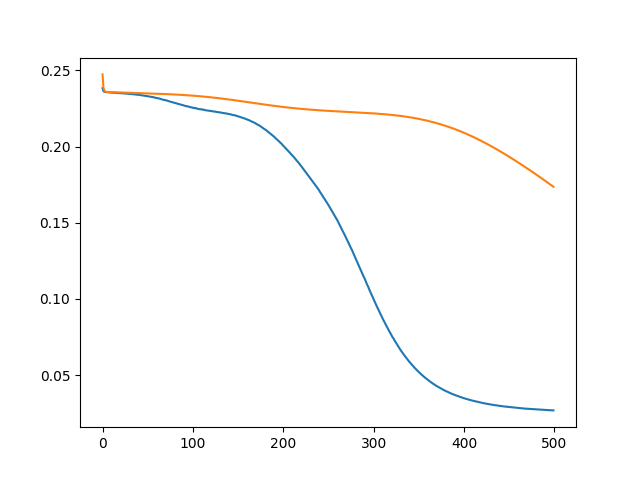

In [24]:
history = training_alg.history['training error']
plt.plot(history)
plt.show()

In [20]:
plt.close()

In [102]:
class TrainingAlgorithm:
    def __init__(self, x_data: pd.DataFrame, y_data: pd.DataFrame, network: NeuralNetwork):
        self.x: np.ndarray = x_data.to_numpy(); self.y: np.ndarray = y_data.to_numpy()
        self.network: NeuralNetwork = network

        self.history: dict[list] = {'training error': []}
        self.cache: dict = {}

class Backpropagation(TrainingAlgorithm):
    def __init__(self, x_data: pd.DataFrame, y_data: pd.DataFrame, network: NeuralNetwork,
                 learning_rate: float,
                 error_function: ErrorFunction, stopping_condition: StoppingCondition,
                 regularization_term: RegularizationTerm = None, batch_size: int = None
                 ):
        super().__init__(x_data, y_data, network)
        self.learning_rate: float = learning_rate
        self.err_fun: ErrorFunction = error_function; self.stop_cond: StoppingCondition = stopping_condition
        self.stop_cond.set_alg(self)


        # The gradients of the loss function (= error function + regularization term) with respect to the network weights and biases.
        # Used for updating the network parameters after each training epoch.
        self.weights_gradient: ListOfArrays = None; self.biases_gradient: ListOfArrays = None
        

        
        self.regularization_term: RegularizationTerm = regularization_term or NoRegularization()
        self.regularization_term.set_network(self.network)

        self.batch_size: int = batch_size or len(self.x)


        self.current_tr_err = float('inf')


    def compute_loss(self, x: np.ndarray, y: np.ndarray) -> float:
        """
        Computes the loss of the current network over the given data.
        Such data may be the whole training data (self.x, self.y) or may be a mini-batch.

        
        Parameters
        ----------
        x: np.ndarray
            The input training (mini)batch data.
        y: np.ndarray
            The output training (mini)batch data.

        Returns
        -------
        loss: float
            Training error + Regularization penalty term. 
        """
        return self.compute_training_error(x, y) + self.regularization_term()
    
    def compute_training_error(self, x: np.ndarray, y: np.ndarray) -> float:
        """
        Computes the error of the current network over the given data.
        Such data may be the whole training data (self.x, self.y) or may be a mini-batch.
        Such error includes no regularization penalty term.


        Parameters
        ----------
        x: np.ndarray
            The input training (mini)batch data.
        y: np.ndarray
            The output training (mini)batch data.        

        Returns
        -------
        error: float
            Average of single-pattern errors over the dataset. 
        """
        network_outputs: np.ndarray = self.network.compute_multiple_outputs(x)
        return self.err_fun(y, network_outputs)
    
    def update_network_parameters(self, current_minibatch_size: int) -> None:
        """
        NOTE TO SELF: add the momentum term's contribution here later.
        Updates the weights and biases of the NeuralNetwork based on the computed gradients and the learning rate.
        """
        factor: float = self.learning_rate * current_minibatch_size / len(self.x)
        # Note that weights and biases are stored in each individual layer, so an iteration over
        # layers is necessary. NeuralNetwork has no weights: ListOfArrays attribute, so we can't just
        # write self.network.weights += ... * self.weights_gradient
        for i, l in enumerate(self.network.layers_with_weights):
            l.weights += factor * self.weights_gradient[i]   
            l.biases += factor * self.biases_gradient[i]
    
    def run(self, max_epochs: int) -> None:
        """
        Train the NeuralNetwork according to this strategy.
        """
        epoch: int = 0; tr_err: float = float('inf')
        indices = np.arange(len(self.x))
        while not self.stop_cond.is_satisfied and epoch < max_epochs:
            epoch += 1; tr_err = 0

            # Shuffle the data
            np.random.shuffle(indices)
            shuffled_x = self.x[indices]; shuffled_y = self.y[indices]

            for start in range(0, len(self.x), self.batch_size):  # For loop over the minibatches.
                end = start + self.batch_size
                minibatch_x = shuffled_x[start:end]; minibatch_y = shuffled_y[start:end]
                current_minibatch_size = len(minibatch_x)

                self.update_gradients(minibatch_x, minibatch_y, cache_error = True)  # NOTE define this function.
                tr_err += self.cache['minibatch_training_error'] * current_minibatch_size / len(self.x)  # Add the error of the minibatch to the whole-batch error.
                self.update_network_parameters(current_minibatch_size)


            self.history['training error'] += [tr_err]
    
    def update_gradients(self, x, y, cache_error: bool) -> None:
        # Set gradients to 0.
        self.reset_gradients()
        if cache_error: self.cache['minibatch_training_error'] = 0
        # Set gradients to the mean of single-pattern gradients of the error (without regularization) function.
        for pattern_x, pattern_y in zip(x,y):
            self.add_single_pattern_gradients_contribution(pattern_x, pattern_y, cache_error)
        current_minibatch_size: int = len(x)
        self.weights_gradient /= current_minibatch_size; self.biases_gradient /= current_minibatch_size
        if cache_error: self.cache['minibatch_training_error'] /= current_minibatch_size
        # Add the regularization term contribution.
        w_reg_term, b_reg_term = self.regularization_term.gradient()
        self.weights_gradient += w_reg_term; self.biases_gradient += b_reg_term
    
    def reset_gradients(self) -> None:
        """
        Sets self.weights_gradient and self.biases_gradient to a list of appropriately-shaped arrays with all zero entries.
        """
        lwws: list[Layer] = self.network.layers_with_weights
        self.weights_gradient = ListOfArrays([np.zeros_like(l.weights) for l in lwws])
        self.biases_gradient = ListOfArrays([np.zeros_like(l.biases) for l in lwws])

    def add_single_pattern_gradients_contribution(self, pattern_x: np.ndarray, pattern_y: np.ndarray, cache_error: bool) -> None:
        predicted_y: np.ndarray = self.network.compute_output(pattern_x)
        if cache_error: self.cache['minibatch_training_error'] += self.err_fun(pattern_y, predicted_y)
        self.backpropagate(pattern_y)

        w_term = ListOfArrays([np.outer(l.previous_layer.output, l.delta) for l in self.network.layers_with_weights])
        b_term = ListOfArrays([l.delta for l in self.network.layers_with_weights])

        self.weights_gradient += w_term; self.biases_gradient += b_term
    
    def backpropagate(self, pattern_y: np.ndarray) -> None:
        out_l: OutputLayer = self.network.output_layer; hid_ls: list[HiddenLayer] = self.network.hidden_layers  # Give short, convenient names to the OutputLayer and the HiddenLayers.

        out_l.delta = out_l.activation_function.derivative(out_l.linear_output) * self.err_fun.simple_gradient(pattern_y, out_l.output)  # Compute delta for the OutputLayer.
        for l in reversed(hid_ls):  # For each HiddenLayer, starting from the one closest to the OutputLayer and proceeding backwards:
            l.delta = l.activation_function.derivative(l.linear_output) * np.dot(l.next_layer.weights, l.next_layer.delta)  # Compute delta for the HiddenLayer.
        



In [282]:
il = InputLayer(17)
hl = HiddenLayer(6, RandomUniform(0.2), Sigmoid())
ol = OutputLayer(2, RandomUniform(0.2), Sigmoid())

nn = NeuralNetwork([il, hl, ol])

training_alg = Backpropagation(x, y, nn, 10.00001, MSE(), ThresholdOnTrainingError(0.00001, 10), regularization_term = Tikhonov(0.000000), batch_size = 2)

training_alg.run(100)

In [ ]:
history = training_alg.history['training error']
plt.plot(history)
plt.show()

In [267]:
plt.close()